In [15]:
import csv
import numpy as np
import os
import pandas as pd
import tqdm
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

traindataset = pd.read_csv("datasetfiletrain.csv", header=0, index_col=0)
X_train = traindataset.iloc[:, :-1].values  # Features
y_train = traindataset.iloc[:, -1].values   # Target

testdataset = pd.read_csv("datasetfiletest.csv", header=0, index_col=0)
X_test = testdataset.iloc[:, :-1].values  # Features
y_test = testdataset.iloc[:, -1].values   # Target

num_features = X_train.shape[1]
bounds = (np.zeros(num_features), np.ones(num_features))

# fitness function for PSO algorithm
def fitness_function(features, ensemble_classifier):
    # Scale features to their weights
    weighted_features = X_train * features

    # Train a classifier (ensemble of RF and SVM) using the selected features
    ensemble_classifier.fit(weighted_features, y_train)
    
    # Evaluate the classifier on the testing set
    weighted_features_test = X_test * features
    y_pred = ensemble_classifier.predict(weighted_features_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Perform feature selection using PSO algorithm
def pso_feature_selection(en_classifier):

    def objective_function(features):
        accuracies = [fitness_function(features[i], en_classifier) for i in range(features.shape[0])]
        return np.array(accuracies)

    # Create a PSO optimizer
    optimizer = GlobalBestPSO(n_particles=5, dimensions=num_features, options= {'c1': 1.25, 'c2': 1.25, 'w': 0.2}, bounds=bounds)

    # Perform optimization
    _, best_feature_weights = optimizer.optimize(objective_function, iters=100, verbose=False)
    
    return best_feature_weights

def experiments(en_classifier, num_iter, use_pso):

  results = np.zeros([3,4])

  # Stores the avg weights decided by PSO
  y = np.zeros([1, num_features], dtype=float)
  
  # Repeat the experiments for iter times
  for i in tqdm.tqdm(range(num_iter)):
    features_train = X_train
    features_test = X_test
    
    if use_pso:
        # Perform feature selection using PSO
        features_weights = pso_feature_selection(en_classifier)
        features_train = X_train * features_weights
        features_test = X_test * features_weights
        y += features_weights

    # Train the final ensemble classifier using the selected features
    en_classifier.fit(features_train, y_train)

    # Evaluate the final ensemble classifier on the testing set
    y_pred = en_classifier.predict(features_test)
    
    #Store the ensemble classifier's results
    results[0,0] += (accuracy_score(y_test, y_pred) * 100/num_iter)
    results[0,1] += (precision_score(y_test, y_pred) * 100/num_iter)
    results[0,2] += (recall_score(y_test,y_pred) * 100/num_iter)
    results[0,3] += (f1_score(y_test, y_pred) * 100/num_iter)
    #print(f"en {results[0,0]:.2f} {y_pred}")

    # Evaluate the individual classifiers
    idx = 1
    for clf in en_classifier.estimators_:
        iy_pred = clf.predict(features_test)

        results[idx,0] += (accuracy_score(y_test, iy_pred) * 100/num_iter)
        results[idx,1] += (precision_score(y_test, iy_pred) * 100/num_iter)
        results[idx,2] += (recall_score(y_test,iy_pred) * 100/num_iter)
        results[idx,3] += (f1_score(y_test, iy_pred) * 100/num_iter)
        #print(f"{idx} {results[idx,0]:.2f} {iy_pred}")
        idx += 1
  
  # scale down the weights by the # of iterations to get the average
  if use_pso:
    y = y / num_iter

  return results, y


def print_results_from_file(filepath):
  with open(filepath,"r") as resultsfile:
    resultscsv = csv.reader(resultsfile)
    next(resultscsv)
    print(f"Classifier\tAccuracy\tPrecision\tRecall\tF1 Score")
    for result in resultscsv:
        print(f"{result[0]:15}\t{float(result[1]):.2f}\t\t{float(result[2]):.2f}\t\t{float(result[3]):.2f}\t{float(result[4]):.2f}")


def store_results(names, results, filepath):
  idx = 0
  with open(filepath, "a", newline='') as resultsfile:
    resultscsv = csv.writer(resultsfile)
    for result in results:
        resultscsv.writerow([names[idx]] + result.tolist())
        idx += 1

def store_weights(classifier_name, weights, filepath):
  with open(filepath, "a", newline='') as resultsfile:
    resultscsv = csv.writer(resultsfile)
    resultscsv.writerow([classifier_name]+weights[0].tolist())

rf_classifier = RandomForestClassifier(min_samples_leaf=4, n_estimators= 30, max_features= 'sqrt')
svm_classifier = SVC(C=100, gamma = 0.001, probability=True)
dt_classifier = DecisionTreeClassifier(criterion= 'gini', max_depth=5, min_samples_split=5)
knn_classifier = KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')
num_iter = 100
resultsfilepath = "experimentresults.csv"
weightsfilepath = "weights.csv"

with open(resultsfilepath, "w", newline='') as resultsfile:
  resultscsv = csv.writer(resultsfile)
  resultscsv.writerow(["Classifier name", "Accuracy", "Precision", "Recall", "F1-Score"])

try:
    os.remove(weightsfilepath)
except:
    pass

print("Just RF and SVM...")
results, _ = experiments(VotingClassifier(estimators=[('rf', rf_classifier), ('svm', svm_classifier)], voting='soft', weights=[5,4]), num_iter, False)
store_results(["RF+SVM","RF","SVM"], results, resultsfilepath)

print("Just DT and KNN...")
results, _ = experiments(VotingClassifier(estimators=[('dt', dt_classifier), ('knn', knn_classifier)], voting='soft', weights=[4,5]), num_iter, False)
store_results(["DT+KNN","DT","KNN"], results, resultsfilepath)

print("PSO with wrapped RF and SVM...")
results, avg_wts = experiments(VotingClassifier(estimators=[('rf', rf_classifier), ('svm', svm_classifier)], voting='soft', weights=[5,4]), num_iter, True)
store_results(["PSO+RF+SVM","PSO+RF","PSO+SVM"], results, resultsfilepath)
store_weights("RF+SVM", avg_wts, weightsfilepath)

print("PSO with wrapped DT and KNN...")
results, avg_wts = experiments(VotingClassifier(estimators=[('dt', dt_classifier), ('knn', knn_classifier)], voting='soft', weights=[4,5]), num_iter, True)
store_results(["PSO+DT+KNN","PSO+DT","PSO+KNN"], results, resultsfilepath)
store_weights("DT+KNN", avg_wts, weightsfilepath)

print_results_from_file(resultsfilepath)

Just RF and SVM...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.03it/s]


Just DT and KNN...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.83it/s]


PSO with wrapped RF and SVM...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [39:07<00:00, 23.48s/it]


PSO with wrapped DT and KNN...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [17:11<00:00, 10.31s/it]


Classifier	Accuracy	Precision	Recall	F1 Score
RF+SVM         	93.56		93.33		100.00	96.54
RF             	93.00		94.48		97.91	96.16
SVM            	89.74		89.74		100.00	94.59
DT+KNN         	98.05		99.77		98.06	98.90
DT             	93.36		96.48		96.11	96.27
KNN            	97.44		97.22		100.00	98.59
PSO+RF+SVM     	93.82		93.57		100.00	96.68
PSO+RF         	93.05		94.49		97.97	96.19
PSO+SVM        	89.74		89.74		100.00	94.59
PSO+DT+KNN     	98.38		99.77		98.43	99.09
PSO+DT         	94.13		96.62		96.86	96.70
PSO+KNN        	98.36		98.22		100.00	99.10


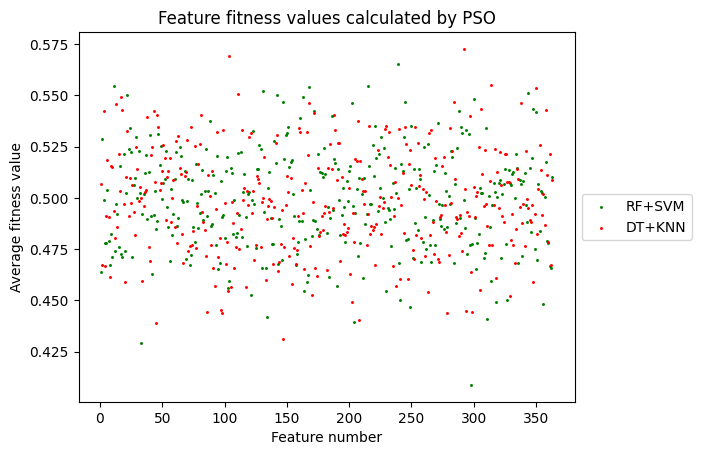

In [12]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot weights calculated by PSO
weights = pd.read_csv("weights.csv", header=None)
x = np.arange(1,weights.shape[1])

est1wts = weights.iloc[0, 1:].values
est1hdr = weights.iloc[0,0]
est2wts = weights.iloc[1, 1:].values
est2hdr = weights.iloc[1,0]

plt.scatter(x, est1wts, color= "green", marker= ".", s=5, label = est1hdr)
plt.scatter(x, est2wts, color= "red", marker= ".", s=5, label = est2hdr)
plt.title("Feature fitness values calculated by PSO")
plt.xlabel("Feature number")
plt.ylabel("Average fitness value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("combinedweightsgraph1.png", dpi=400, bbox_inches='tight')
plt.show()